In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-paper')
import seaborn as sns
import joblib
import numpy as np
import pandas as pd
plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
import pickle

C:\Users\aa271\AppData\Local\Temp\ipykernel_23600\1501702544.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [2]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor,RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_objective
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, MultiTaskLassoCV
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, MultiTaskLassoCV
from econml.dml import DML
from sklearn.preprocessing import StandardScaler

In [3]:
columnnameen = ['Isoprene',
    '1,3-Butadiene',
    'Butene',
    'Pentene',
                'NOx',
                'O$_3$',
                'PM$_1$',
                'SO$_2$',
                'Radiation',
                'Temperature',
                'Humidity',
                'TICCLabel',
                'Month',
                'KMeansLabel']
columnname = [
   'Isoprene',
    '1,3-Butadiene',
    'Butene',
    'Pentene',
    'NOx',
    'O3',
    'PM1',
    'SO2',
    'Radiation',
    'Temperature',
    'Humidity',
    'TICCLabel',
    "Place",
    'Month',
    'KMeansLabel'
]

Xcolname=[   'NOx',
    'O$_3$',
    'SO$_2$',
    'Radiation',
    'Temperature',
    'Humidity',
            ]

Tname = ['Isoprene',
    '1,3-Butadiene',
    'Butene',
    'Pentene']
yname = ['PM1']
Xname = ['NOx',
         'O3',
         'SO2',
         'Radiation',
         'Temperature',
         'Humidity', ]
Wname = ["Place",
         'Month',
         'KMeansLabel']

In [4]:
data = pd.read_excel("dataDMLnoscale.xlsx", index_col=0)

In [5]:
# data=grouped_data
data.columns=columnname
X=data[Xname]
T=data[Tname]
y=np.array(data[yname]).ravel()
Dummy=[pd.get_dummies(data[i], prefix=i,drop_first=True) for i in Wname]
W=pd.concat([Dummy[0],Dummy[1],Dummy[2]], axis=1)

# Use StandardScaler to normalize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=Xname)

In [6]:
from sklearn.model_selection import train_test_split

# 将数据集分割为训练集和测试集（例如，80% 训练，20% 测试）
X_train, X_test, T_train, T_test, W_train, W_test, y_train, y_test = train_test_split(
    X_scaled, T, W, y, test_size=0.2, random_state=42
)

In [7]:
import pickle
with open('bayes_search_results_y.pkl', 'rb') as file:
    bayes_search_results_y = pickle.load(file)
with open('bayes_search_results_t.pkl', 'rb') as file:
    bayes_search_results_t = pickle.load(file)
with open('mse_results.pkl', 'rb') as file:
    mse_results = pickle.load(file)

In [8]:
# 找到最佳模型的名称和实例
best_model_y_name = min((k for k in mse_results if 'model_y' in mse_results[k]),
                        key=lambda k: mse_results[k]['model_y'])
best_model_t_name = min((k for k in mse_results if 'model_t' in mse_results[k]),
                        key=lambda k: mse_results[k]['model_t'])

best_model_y = bayes_search_results_y[best_model_y_name].best_estimator_
best_model_t = bayes_search_results_t[best_model_t_name].best_estimator_


print(f"Best model_y name: {best_model_y_name}")
print(f"Best model_t name: {best_model_t_name}")
print("Best model_y instance:", best_model_y)
print("Best model_t instance:", best_model_t)

Best model_y name: GradientBoostingRegressor
Best model_t name: GradientBoostingRegressor
Best model_y instance: Pipeline(steps=[('model',
                 GradientBoostingRegressor(learning_rate=0.10422385851639915,
                                           max_depth=8, max_features='sqrt',
                                           n_estimators=500, subsample=0.5))])
Best model_t instance: Pipeline(steps=[('model',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.07007568334197407,
                                                                          max_depth=8,
                                                                          max_features='sqrt',
                                                                          n_estimators=500,
                                                                          subsample=0.5351680873953943)))])


In [16]:
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso
from sklearn.preprocessing import PolynomialFeatures
from skopt import Optimizer as BayesianOptimization
from skopt.space import Real, Integer, Categorical

# 初始化 Y 和 T 的模型。在这种情况下，我们使用您提供的模型。
model_y = best_model_y
model_t = best_model_t

In [ ]:

# 初始估计器的设置
est = DML(model_y=model_y,
          model_t=model_t,
          model_final=MultiOutputDebiasedLasso(fit_intercept=False),
          discrete_treatment=False,
          linear_first_stages=False,
          cv=5,
          fit_cate_intercept=True,
          random_state=123)

# 使用训练数据进行拟合
est.fit(Y=y_train, T=T_train, X=X_train, W=W_train, cache_values=True)
# import pickle
# with open('first_stage.pkl', 'wb') as file:
#     pickle.dump(est, file)

In [ ]:
import pickle
with open('first_stage.pkl', 'rb') as file:
    est = pickle.load(file)

In [17]:
# 定义目标函数
def objective(alpha_cov, max_iter, tol, n_alphas, n_alphas_cov):
    # 设置第二阶段模型
    model_final = MultiOutputDebiasedLasso(alpha='auto',
                                           n_alphas=int(n_alphas),
                                           alpha_cov=alpha_cov,
                                           n_alphas_cov=int(n_alphas_cov),
                                           fit_intercept=False,
                                           max_iter=int(max_iter),
                                           tol=tol,
                                           n_jobs=-1,  # 使用所有可用的 CPU
                                           random_state=123)

    est.model_final = model_final

    # 使用缓存的值重新拟合最后阶段
    est.refit_final()

    # 使用测试数据评估模型
    mse = est.score(Y=y_test, T=T_test, X=X_test, W=W_test)
    return -mse  # 我们需要返回负MSE，因为我们想最小化它


# 定义超参数空间
param_space = [
    Real(1e-5, 1e-1, prior='log-uniform', name="alpha_cov"),  # Regularization strength for covariance
    Integer(100, 5000, name="max_iter"),  # Maximum number of iterations
    Real(1e-6, 1e-1, prior='log-uniform', name="tol"),  # Tolerance for stopping criteria
    Integer(10, 200, name="n_alphas"),  # Number of alphas for main regression
    Integer(2, 20, name="n_alphas_cov")  # Number of alphas for covariance
]

# 初始化BayesianOptimization
optimizer = BayesianOptimization(
    dimensions=param_space,
    random_state=1145,
    base_estimator="GP"
)
# 执行贝叶斯优化
from tqdm import tqdm



In [ ]:
from tqdm import tqdm
# 使用 tqdm 包装 range 函数，以添加进度条
for i in tqdm(range(100), desc="Optimizing", ncols=100):
    next_x = optimizer.ask()  # 请求下一组超参数
    f_val = objective(*next_x)  # 计算目标函数值
    optimizer.tell(next_x, f_val)  # 告诉优化器结果

In [ ]:
# import pickle
# with open('optimizer.pkl', 'wb') as file:
#     pickle.dump(optimizer, file)

In [ ]:
# 使用找到的最佳参数在整个数据集上重新训练模型
best_params = optimizer.Xi[np.argmin(optimizer.yi)]
alpha_cov_best, max_iter_best, tol_best, n_alphas_best, n_alphas_cov_best = best_params

# 使用这些最佳参数设置第二阶段模型
model_final_best = MultiOutputDebiasedLasso(alpha='auto',
                                           n_alphas=int(n_alphas_best),
                                           alpha_cov=alpha_cov_best,
                                           n_alphas_cov=int(n_alphas_cov_best),
                                           fit_intercept=False,
                                           max_iter=int(max_iter_best),
                                           tol=tol_best,
                                           n_jobs=-1,
                                           random_state=123)

# 使用最佳参数创建新的估计器实例并拟合所有数据
estimator = DML(model_y=model_y,
               model_t=model_t,
               model_final=model_final_best,
               discrete_treatment=False,
               linear_first_stages=False,
               cv=5,
               fit_cate_intercept=True,
               random_state=123)

estimator.fit(Y=y, T=T, X=X, W=W)

# with open('estimator.pkl', 'wb') as file:
#     pickle.dump(estimator, file)

In [ ]:
# 使用找到的最佳参数在整个数据集上重新训练模型
best_params = optimizer.Xi[np.argmin(optimizer.yi)]
alpha_cov_best, max_iter_best, tol_best, n_alphas_best, n_alphas_cov_best = best_params

# 使用这些最佳参数设置第二阶段模型
model_final_best = MultiOutputDebiasedLasso(alpha='auto',
                                            n_alphas=int(n_alphas_best),
                                            alpha_cov=alpha_cov_best,
                                            n_alphas_cov=int(n_alphas_cov_best),
                                            fit_intercept=False,
                                            max_iter=int(max_iter_best),
                                            tol=tol_best,
                                            n_jobs=-1,
                                            random_state=123)

# 使用最佳参数创建新的估计器实例并拟合所有数据
estimator = DML(model_y=model_y,
                model_t=model_t,
                model_final=model_final_best,
                discrete_treatment=False,
                linear_first_stages=False,
                cv=5,
                fit_cate_intercept=True,
                random_state=123)

estimator.fit(Y=y_train, T=T_train, X=X_train, W=W_train)
# with open('estimator_train.pkl', 'wb') as file:
#     pickle.dump(estimator, file)

In [23]:
with open('estimator_train.pkl', 'rb') as file:
    estimator = pickle.load(file)
with open('optimizer.pkl', 'rb') as file:
    optimizer = pickle.load(file)

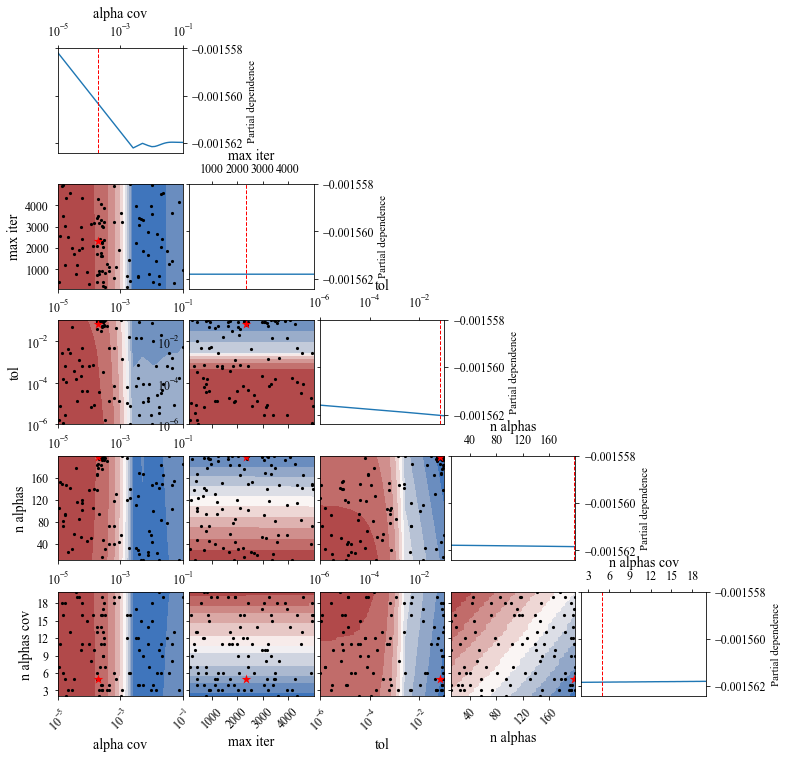

In [24]:
from skopt.plots import plot_objective
param_names =  [dim.name.replace('_',' ') for dim in param_space]

# 使用 plot_objective 函数
axes = plot_objective(result=optimizer.get_result(), cmap='vlag', dimensions=param_names)
# 遍历子图的轴对象，设置刻度和标签的大小
for i in range(len(axes)):
    for j in range(len(axes)):
        ax = axes[i, j]
        if i == j:
            ax.set_ylabel(ax.get_ylabel(), fontsize=11)  # 对角线上的子图，设置较大的字体大小
            ax.tick_params(axis='both', labelsize=12)  # 非对角线上的子图，设置较小的刻度字体大小
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # 非对角线上的子图，设置较小的x轴标签字体大
        else:
            ax.tick_params(axis='both', labelsize=12)  # 非对角线上的子图，设置较小的刻度字体大小
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # 非对角线上的子图，设置较小的x轴标签字体大小
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)  # 非对角线上的子图，设置较小的y轴标签字体大小

# plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.05)
plt.savefig("finalmodel_objective.svg", bbox_inches='tight')
plt.show()

In [12]:
estimator.summary(feature_names=Xname, treatment_names=Tname)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
NOx|Isoprene,0.059,0.044,1.336,0.182,-0.027,0.145
"NOx|1,3-Butadiene",-0.133,0.051,-2.612,0.009,-0.232,-0.033
NOx|Butene,0.356,0.016,21.998,0.0,0.324,0.387
NOx|Pentene,0.072,0.025,2.83,0.005,0.022,0.121
O3|Isoprene,0.185,0.03,6.109,0.0,0.125,0.244
"O3|1,3-Butadiene",0.491,0.048,10.332,0.0,0.398,0.585
O3|Butene,-0.501,0.014,-37.017,0.0,-0.527,-0.474
O3|Pentene,-0.003,0.018,-0.196,0.844,-0.038,0.031
SO2|Isoprene,-0.1,0.035,-2.852,0.004,-0.169,-0.031
"SO2|1,3-Butadiene",-0.214,0.046,-4.681,0.0,-0.304,-0.125
